In [3]:
# imports
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import ttest_ind, permutation_test

In [4]:
pl.Config.load_from_file("../polars_cfg.json")

# 1. Data loading / processing


In [5]:
# data file paths
clean_summary_path = "../data/clean_summary_data.csv"
clean_summary_incomplete_path = "../data/clean_summary_data_incomplete.csv"
clean_demographics_path = "../data/clean_demographics_data.csv"

In [6]:
# load data
df_summary = pl.read_csv(clean_summary_path).select(
    "hashed_id", "task_number", "solved", "task_type"
)
df_summary_incomplete = pl.read_csv(clean_summary_incomplete_path).select(
    "hashed_id", "task_number", "solved", "task_type"
)
df_demographics = pl.read_csv(clean_demographics_path)

In [7]:
# proportion solved per participant
participants_max_tasks = df_summary.group_by("hashed_id").agg(
    pl.max("task_number"), pl.first("task_type")
)
participants_max_tasks = participants_max_tasks.rename(
    {"task_number": "max_task_number"}
)
df_summary = df_summary.join(participants_max_tasks, on="hashed_id")
proportion_solved = df_summary.group_by("hashed_id").agg(
    (pl.sum("solved") / pl.max("max_task_number")).alias("success_rate"),
    pl.first("task_type"),
)

In [8]:
# make demographic data frame
dem = df_demographics.join(proportion_solved, on="hashed_id")
dem = dem.with_columns(
    gender=pl.when(pl.col("gender") == "Man")
    .then(pl.lit("male"))
    .when(pl.col("gender") == "Woman")
    .then(pl.lit("female"))
    .when(
        pl.col("gender").is_null()
        | (pl.col("gender") == "Non-binary/Genderqueer")
        | (pl.col("gender") == "Prefer not to specify")
        | (pl.col("gender") == "Other")
    )
    .then(pl.lit("other"))
    .otherwise((pl.col("gender"))),
    age=pl.col("age").cast(pl.Float32),
)

In [10]:
# how many are null?
print(
    f"Number of null education level entries: {dem.filter(pl.col('education_level').is_null()).shape[0]}"
)

Number of null education level entries: 223


# 2. Demographics


## Gender


In [11]:
for task_type in ["training", "evaluation"]:
    print(f"{task_type.capitalize()} tasks gender distribution")
    print(
        dem.filter(pl.col("task_type") == task_type)
        .group_by("gender")
        .agg(
            (pl.len() / dem.filter(pl.col("task_type") == task_type).shape[0] * 100)
            .alias("percentage")
            .round(1)
        )
    )
    print()

Training tasks gender distribution
shape: (3, 2)
┌────────┬────────────┐
│ gender ┆ percentage │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ other  ┆ 2.5        │
│ female ┆ 37.3       │
│ male   ┆ 60.2       │
└────────┴────────────┘

Evaluation tasks gender distribution
shape: (3, 2)
┌────────┬────────────┐
│ gender ┆ percentage │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ male   ┆ 51.1       │
│ female ┆ 46.0       │
│ other  ┆ 2.8        │
└────────┴────────────┘



## Age


In [12]:
# print age stats
print(dem.select("age").describe())

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ age       │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 1412.0    │
│ null_count ┆ 13.0      │
│ mean       ┆ 39.765579 │
│ std        ┆ 10.408503 │
│ min        ┆ 1.0       │
│ 25%        ┆ 33.0      │
│ 50%        ┆ 38.0      │
│ 75%        ┆ 46.0      │
│ max        ┆ 77.0      │
└────────────┴───────────┘


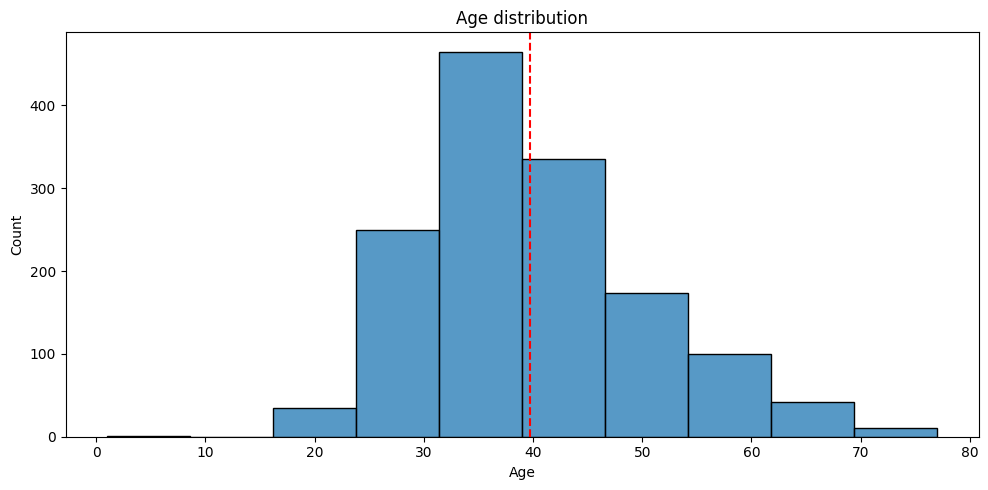

In [13]:
# plot age distribution
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=dem, x="age", bins=10)
plt.xlabel("Age")
plt.axvline(dem.select("age").mean().to_numpy()[0, 0], color="red", linestyle="--")
plt.title("Age distribution")
plt.tight_layout()
plt.savefig("../figures/age_dist.png", dpi=300, bbox_inches="tight")
plt.show()

## Education


In [14]:
# bin participants in low / high education
low_edu = [
    "High School Diploma",
    "Technical/Community College",
    "Secondary Education",
    "No Formal Qualifications",
]
high_edu = ["Undergraduate", "Graduate", "Doctorate"]
dem = dem.with_columns(
    pl.when(pl.col("education_level").str.contains_any(high_edu))
    .then(pl.lit("higher_edu"))
    .when(pl.col("education_level").str.contains_any(low_edu))
    .then(pl.lit("lower_edu"))
    .otherwise(pl.lit("unspecified"))
    .alias("education")
)

In [15]:
# inspect success rate by education level
mean_succ_rate_by_edu = dem.group_by("education").agg(pl.col("success_rate").mean())
print(mean_succ_rate_by_edu)

shape: (3, 2)
┌─────────────┬──────────────┐
│ education   ┆ success_rate │
│ ---         ┆ ---          │
│ str         ┆ f64          │
╞═════════════╪══════════════╡
│ lower_edu   ┆ 0.699754     │
│ higher_edu  ┆ 0.69784      │
│ unspecified ┆ 0.792733     │
└─────────────┴──────────────┘


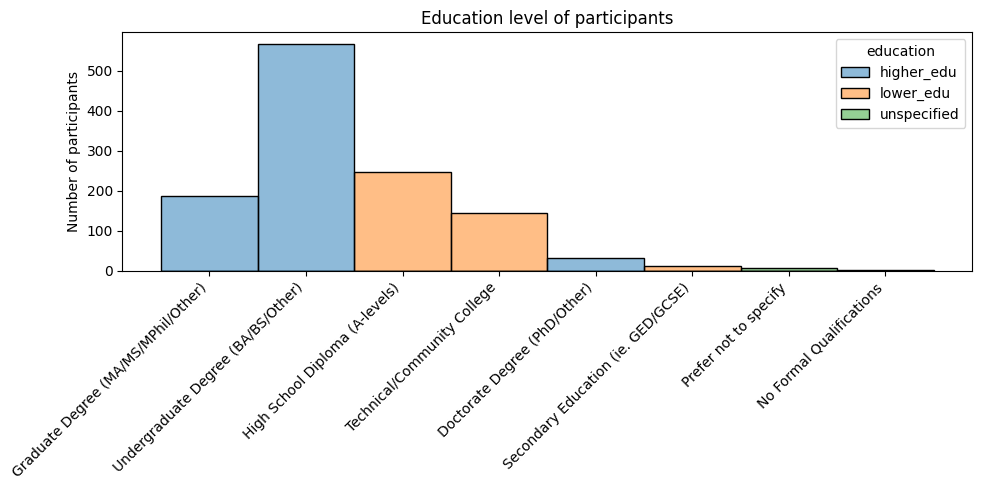

In [16]:
# plot education level distribution
fig = plt.figure(figsize=(10, 5))
sns.histplot(dem, x="education_level", hue="education")
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Number of participants")
plt.title("Education level of participants")
plt.tight_layout()
plt.savefig("../figures/education_level.png", dpi=300, bbox_inches="tight")
plt.show()

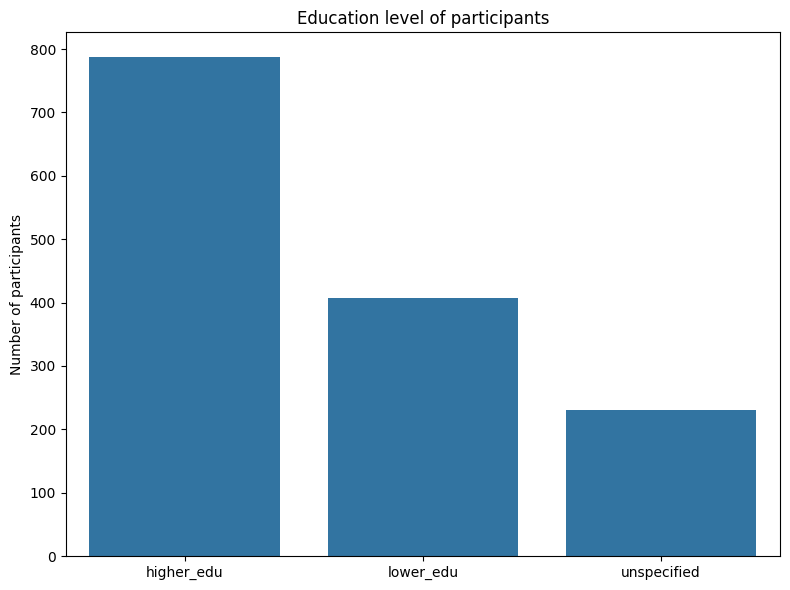

In [17]:
# plot binned education level distribution
fig = plt.figure(figsize=(8, 6))
sns.countplot(dem, x="education")
plt.xlabel("")
plt.ylabel("Number of participants")
plt.title("Education level of participants")
plt.tight_layout()
plt.savefig("../figures/education_level_agg.png", dpi=300, bbox_inches="tight")
plt.show()

## Success rate x Education level


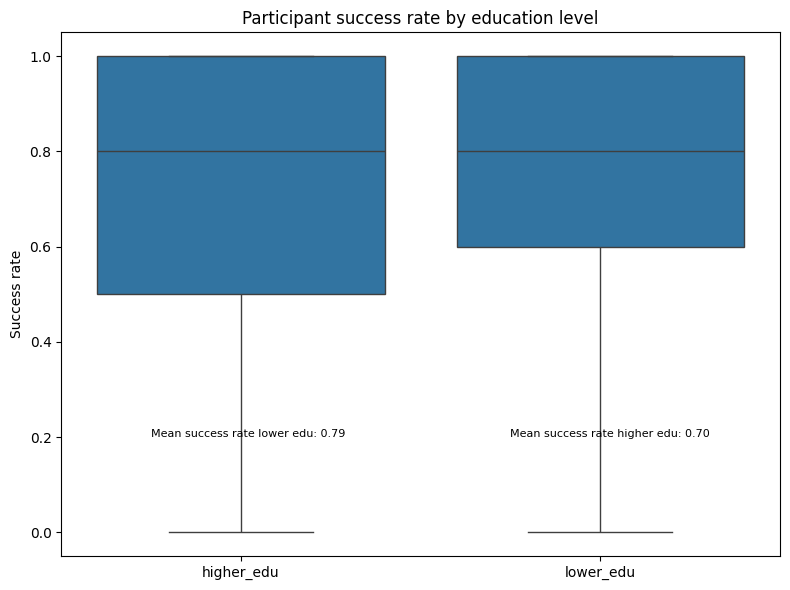

In [18]:
# plot success rate by education level
fig = plt.figure(figsize=(8, 6))
sns.boxplot(
    data=dem.filter(pl.col("education") != "unspecified"),
    x="education",
    y="success_rate",
)
plt.xlabel("")
plt.ylabel("Success rate")
plt.title("Participant success rate by education level")
plt.text(
    0.75,
    0.2,
    f"Mean success rate higher edu: {mean_succ_rate_by_edu[1, 1]:.2f}",
    fontsize=8,
)
plt.text(
    -0.25,
    0.2,
    f"Mean success rate lower edu: {mean_succ_rate_by_edu[2, 1]:.2f}",
    fontsize=8,
)
plt.tight_layout()
plt.savefig("../figures/success_rate_by_edu.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
# run t-test
higher_edu = (
    dem.filter(pl.col("education") == "higher_edu")
    .select("success_rate")
    .to_numpy()
    .flatten()
)
lower_edu = (
    dem.filter(pl.col("education") == "lower_edu")
    .select("success_rate")
    .to_numpy()
    .flatten()
)

t_stat, p_val = ttest_ind(higher_edu, lower_edu)
print(f"t-statistic: {t_stat}, p-value: {p_val}")
print(f"Degrees of freedom: {len(higher_edu) + len(lower_edu) - 2}")

t-statistic: -0.09538237319305869, p-value: 0.9240271482480902
Degrees of freedom: 1192


We find no significant effect of education level on performance!
